In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 25)
import matplotlib as plt
import matplotlib.pyplot as plt


In [ ]:
import networkx as nx


I'll start by downloading the rideshare data for January. Everything is on this website, including data dictionaries and shape files for taxi zones: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
JanFHVHV = pd.read_parquet(r'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-01.parquet')


In [4]:
JanFHVHV
#185M cells, just for January.

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-01-01 00:18:06,2023-01-01 00:19:24,2023-01-01 00:19:38,2023-01-01 00:48:07,48,68,0.94,...,2.30,2.75,0.0,5.22,27.83,N,N,,N,N
1,HV0003,B03404,B03404,2023-01-01 00:48:42,2023-01-01 00:56:20,2023-01-01 00:58:39,2023-01-01 01:33:08,246,163,2.78,...,5.34,2.75,0.0,0.00,50.15,N,N,,N,N
2,HV0003,B03404,B03404,2023-01-01 00:15:35,2023-01-01 00:20:14,2023-01-01 00:20:27,2023-01-01 00:37:54,9,129,8.81,...,2.16,0.00,0.0,0.00,20.22,N,N,,N,N
3,HV0003,B03404,B03404,2023-01-01 00:35:24,2023-01-01 00:39:30,2023-01-01 00:41:05,2023-01-01 00:48:16,129,129,0.67,...,1.22,0.00,0.0,0.00,7.90,N,N,,N,N
4,HV0003,B03404,B03404,2023-01-01 00:43:15,2023-01-01 00:51:10,2023-01-01 00:52:47,2023-01-01 01:04:51,129,92,4.38,...,1.82,0.00,0.0,0.00,16.48,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479026,HV0003,B03404,B03404,2023-01-31 23:33:42,2023-01-31 23:37:04,2023-01-31 23:39:34,2023-01-31 23:45:11,161,100,0.67,...,1.31,2.75,0.0,0.00,10.62,N,N,,N,N
18479027,HV0003,B03404,B03404,2023-01-31 23:31:20,2023-01-31 23:35:17,2023-01-31 23:35:25,2023-01-31 23:47:28,129,56,2.04,...,0.88,0.00,0.0,0.00,9.82,N,N,,N,N
18479028,HV0003,B03404,B03404,2023-01-31 23:15:39,2023-01-31 23:16:35,2023-01-31 23:18:09,2023-01-31 23:34:46,234,236,4.14,...,3.41,2.75,0.0,0.00,24.22,N,N,,N,N
18479029,HV0003,B03404,B03404,2023-01-31 23:40:03,2023-01-31 23:41:31,2023-01-31 23:44:07,2023-01-31 23:52:16,237,163,1.10,...,1.37,2.75,0.0,0.00,12.62,N,N,,N,N


In [5]:
JanFHVHV.isna().sum()
#nulls are mostly not a problem. 
# exception is originating_base_num (originating_base_num base number of the base that received the original trip request)
#on_scene_datetime date/time when driver arrived at the pick-up location (Accessible data only) -- makes sense as most rides are not 'accessible'

hvfhs_license_num             0
dispatching_base_num          0
originating_base_num    4891992
request_datetime              0
on_scene_datetime       4891992
pickup_datetime               0
dropoff_datetime              0
PULocationID                  0
DOLocationID                  0
trip_miles                    0
trip_time                     0
base_passenger_fare           0
tolls                         0
bcf                           0
sales_tax                     0
congestion_surcharge          0
airport_fee                   0
tips                          0
driver_pay                    0
shared_request_flag           0
shared_match_flag             0
access_a_ride_flag            0
wav_request_flag              0
wav_match_flag                0
dtype: int64

I just want to check if there is plenty of outer borough data (non-manhattan). I took a brief look at yellow cab taxi data and it wasn't there.

In [6]:
JanFHVHVborocount = pd.DataFrame(JanFHVHV['PULocationID'].value_counts())
dfTaxiZones = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")
dfTaxiZones
JanFHVHVborocount = pd.merge(JanFHVHVborocount, dfTaxiZones, left_on='PULocationID', right_on='LocationID', how='left')
JanFHVHVborocount.groupby('Borough').sum()['count']


Borough
Bronx            2197976
Brooklyn         4784586
EWR                    4
Manhattan        7578803
Queens           3666870
Staten Island     249800
Unknown              992
Name: count, dtype: int64

lots and lots of boro data :) -- this is in contrast to yellow cab data, which has almost no outer boro data

Now, let's create a histogram to see people's trip distances

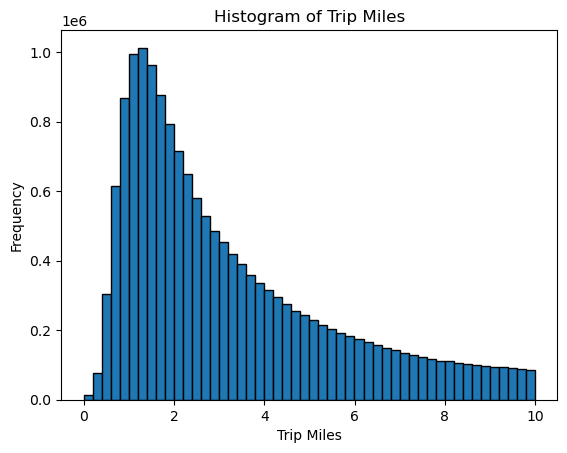

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(filtered_df, bins=50, edgecolor='black')
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles')
plt.show()
#trips become more frequent up until about a mile then get less and less frequent
#Question for later: I wonder if most picukup and dropoff zones are the same
#Answer from much later in my EDA: usually, the most common pickup zone for any given dropoff zone is an adjacent district. 
#I should probably confirm this as I know this from clicking around a map, rather than an official analysis.

In [49]:
#curious how much money is spent on < 2 mile trips
lessthan2miletrips = JanFHVHV.loc[JanFHVHV['trip_miles'] < 2, ['trip_miles','tips','driver_pay'] ]
lessthan2miletrips['cost'] = lessthan2miletrips['tips'] + lessthan2miletrips['driver_pay']

In [51]:
lessthan2miletrips['cost'].sum()
#54M in January!

54030383.35000001

This has given me a basic sense of the available columns and expectations for size and patterns in the data. Most rideshare data for the past 4 years is in FHVHV files, a code the city uses for the rideshare apps that have the most rides. I aggregated the data by hour in another file, File_compressor_NYCTaxisAndRideshares. I will now use the aggregated data to do EDA.

I'd like to look at trends during the entire 4-year span that I currently have access to. I'm going to look at rides to airport since I think that could be an interesting proxy for pandemic movement and recovery -- during the pandemic, flight passenger numbers was often used as a realtime statistic.

In [9]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2019_2020.parquet')

In [10]:
ridestoairport = rideshares.loc[(rideshares['DOLocationID']==1) | (rideshares['DOLocationID']==132) | (rideshares['DOLocationID']==138),:]
ridestoairport20192020 = pd.DataFrame(ridestoairport.groupby(['Year', 'Month'])['trips'].sum())
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2021.parquet')
ridestoairport = rideshares.loc[(rideshares['DOLocationID']==1) | (rideshares['DOLocationID']==132) | (rideshares['DOLocationID']==138),:]
ridestoairport2021 = pd.DataFrame(ridestoairport.groupby(['Year', 'Month'])['trips'].sum())
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2022_2023.parquet')
ridestoairport = rideshares.loc[(rideshares['DOLocationID']==1) | (rideshares['DOLocationID']==132) | (rideshares['DOLocationID']==138),:]
ridestoairport20222023 = pd.DataFrame(ridestoairport.groupby(['Year', 'Month'])['trips'].sum())
ridestoairportbymonthfull = pd.concat([ridestoairport20192020, ridestoairport2021, ridestoairport20222023], axis=0)
ridestoairportbymonthfull = pd.DataFrame(ridestoairportbymonthfull.groupby(['Year','Month'])['trips'].sum())
ridestoairportbymonthfull = ridestoairportbymonthfull.reset_index()
ridestoairportbymonthfull

,Year,Month,trips
0,2019,2,770373
1,2019,3,935486
2,2019,4,888475
3,2019,5,1012771
4,2019,6,927666
...,...,...,...
47,2023,1,808103
48,2023,2,795754
49,2023,3,991986
50,2023,4,934181


In [11]:
ridestoairportbymonthfull = ridestoairportbymonthfull.drop(51)

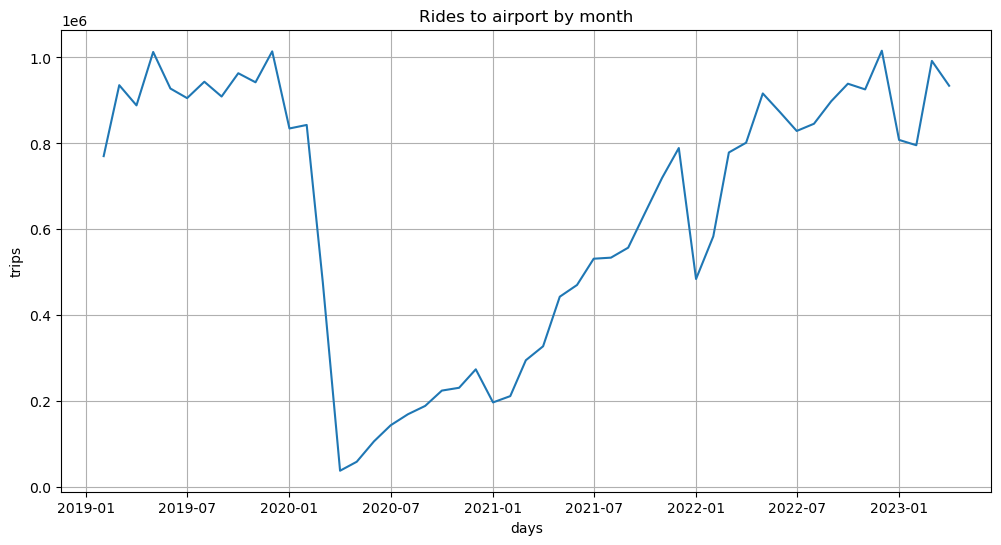

In [12]:
ridestoairportbymonthfull['year-month'] = pd.to_datetime(ridestoairportbymonthfull['Year'].astype(str) + '-' + ridestoairportbymonthfull['Month'].astype(str).str.zfill(2))
Months = ridestoairportbymonthfull['year-month']
Trips = ridestoairportbymonthfull['trips']
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Months, Trips)

ax.set(xlabel='days', ylabel='trips',
       title='Rides to airport by month')
ax.grid()
plt.show()


Wow, this is crystal clear. Let's see how this compares to full year numbers.

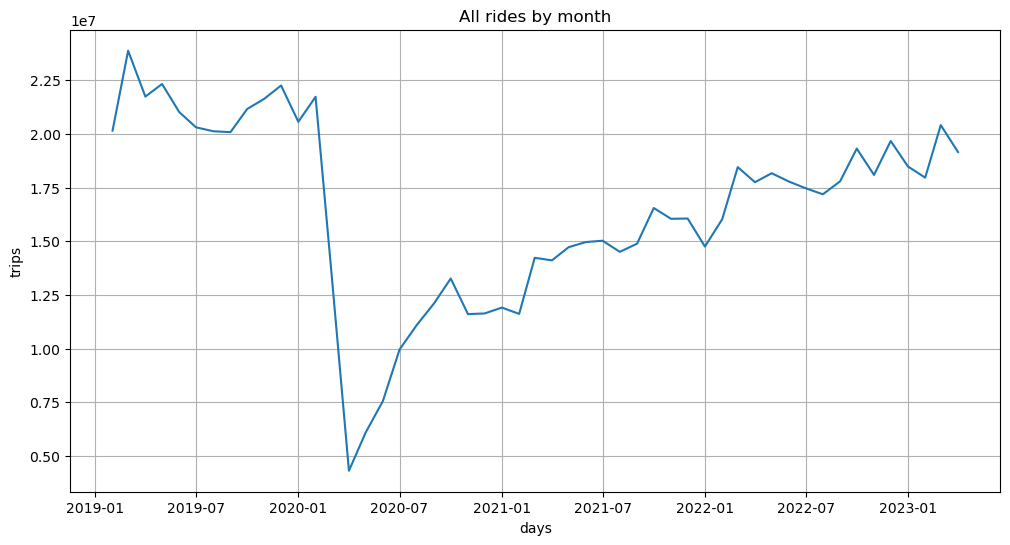

In [15]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2019_2020.parquet')
rides20192020summary = pd.DataFrame(rideshares.groupby(['Year', 'Month'])['trips'].sum())
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2021.parquet')
rides2021summary = pd.DataFrame(rideshares.groupby(['Year', 'Month'])['trips'].sum())
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2022_2023.parquet')
rides20222023summary = pd.DataFrame(rideshares.groupby(['Year', 'Month'])['trips'].sum())
ridesfullsummary = pd.concat([rides20192020summary, rides2021summary, rides20222023summary], axis=0)
ridesfullsummary = pd.DataFrame(ridesfullsummary.groupby(['Year','Month'])['trips'].sum())
ridesfullsummary = ridesfullsummary.reset_index()
ridesfullsummary['year-month'] = pd.to_datetime(ridesfullsummary['Year'].astype(str) + '-' + ridesfullsummary['Month'].astype(str).str.zfill(2))
ridesfullsummary = ridesfullsummary.drop(51)
Months = ridesfullsummary['year-month']
Trips = ridesfullsummary['trips']
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Months, Trips)

ax.set(xlabel='days', ylabel='trips',
       title='All rides by month')
ax.grid()
plt.show()

In [42]:
ridesfullsummary['trips'].sum()


840945115

Basically, really really similar graphs. Airport rides appears a bit more sensitive, especially to the Jan 2022 Omicron wave. Let me graph these two on the same plot.

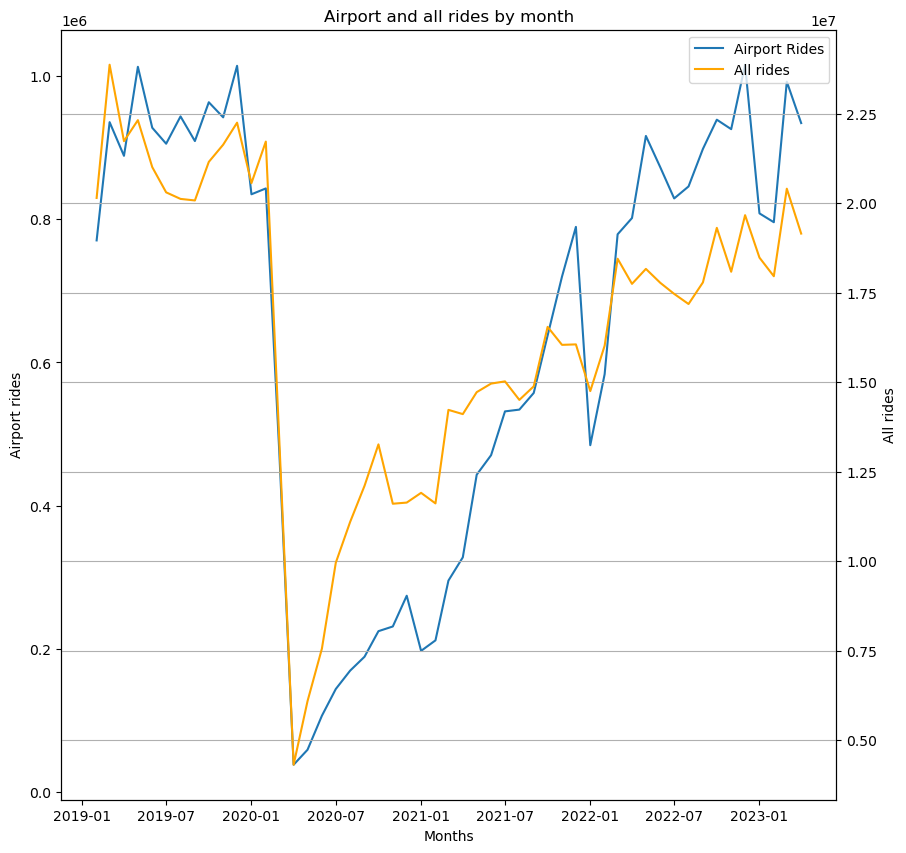

In [16]:
months = ridesfullsummary['year-month']
airportrides = ridestoairportbymonthfull['trips']
allrides = ridesfullsummary['trips']
plt.figure(figsize=(10, 10)) 
line1, = plt.plot(months, airportrides, label='Airport Rides')
plt.xlabel('Months')
plt.ylabel('Airport rides')
plt.title('Airport and all rides by month')
plt.twinx()
line2, = plt.plot(months, allrides, label='All rides', color='orange')
plt.ylabel('All rides', color='black')
lines = [line1, line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)
plt.grid(True)
plt.show()


Really interesting. Looks like airport rides initially lagged regular ride usage (relatively), then recovered faster. However, it was more sensitive to the omicron wave. Also, while the airports have fully recovered, the total ridership of New Yorkers has not.

I'd like to map how the pandemic affected work commutes in New York. Since Q4 2019 was the last fully normal quarter and Q4 2022 appears to be close to fully recovered in terms of total rides, I think this will make for a fruitful comparison.

In [17]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2019_2020.parquet')
rideshares2019Q4morning = rideshares.loc[
    (
       ((rideshares['Month'] == 10) |(rideshares['Month'] == 11) | (rideshares['Month'] == 12)) & #Q4
    ((rideshares['Year'] == 2019) | (rideshares['Year'] == 2022))
     & ((rideshares['Hour']>=7) & (rideshares['Hour']<=10)) #most popular commuter hours for the overall dataset
    )
]
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2022_2023.parquet')
rideshares2022Q4morning = rideshares.loc[
    (
       ((rideshares['Month'] == 10) |(rideshares['Month'] == 11) | (rideshares['Month'] == 12)) &
    ((rideshares['Year'] == 2019) | (rideshares['Year'] == 2022))
     & ((rideshares['Hour']>=7) & (rideshares['Hour']<=10))
    )
]


In [18]:
morningcommutesq420192022 = pd.concat([rideshares2022Q4morning, rideshares2019Q4morning], axis=0)
zones = pd.read_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\taxi+_zone_lookup.csv')
morningcommutesq420192022 = pd.merge(morningcommutesq420192022, zones, left_on='DOLocationID', right_on='LocationID', how='inner')
morningcommutesq420192022manhattan = morningcommutesq420192022.loc[morningcommutesq420192022['Borough']=='Manhattan',:]
morningcommutesq420192022manhattan.head

<bound method NDFrame.head of          PULocationID  DOLocationID  Year  Month  Day  Hour  trip_miles_sum  \
77333               2           230  2022     10    9     7          18.336   
77334               3           230  2022     10    3     9          33.885   
77335               3           230  2022     10    3    10          13.640   
77336               3           230  2022     10    4     9          15.058   
77337               3           230  2022     10    5     7          16.390   
...               ...           ...   ...    ...  ...   ...             ...   
6945731           181           105  2019     10    4     7           3.526   
6945732           195           105  2019     10   31    10           3.300   
6945733           188           105  2019     11    8     8           9.026   
6945734           132           105  2019     12    6     8          26.240   
6945735           143           105  2019     12   17     7           8.920   

         congestion_s

In [19]:
groupby = morningcommutesq420192022manhattan.groupby(['PULocationID','Year'])['trips'].sum()
groupby = groupby.unstack()
groupby = groupby.reset_index()
groupby['Yearly comparsion'] = (groupby[2022] - groupby[2019])/groupby[2019]

In [20]:
groupby #comparison of mornning commutes by pickup zone, Q4 2022 vs. Q4 2019

Year,PULocationID,2019,2022,Yearly comparsion
0,1,265.0,NaN,NaN
1,2,NaN,5.0,NaN
2,3,1657.0,1890.0,0.140616
3,4,47118.0,23441.0,-0.502504
4,5,64.0,94.0,0.468750
...,...,...,...,...
258,261,18441.0,18894.0,0.024565
259,262,74892.0,45646.0,-0.390509
260,263,67161.0,47881.0,-0.287071
261,264,1.0,NaN,NaN


In [21]:
groupby.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\morningcommutestomanhattanq4comparison.csv', index=False)
#exporting this so I can plug it into a map in tableau.


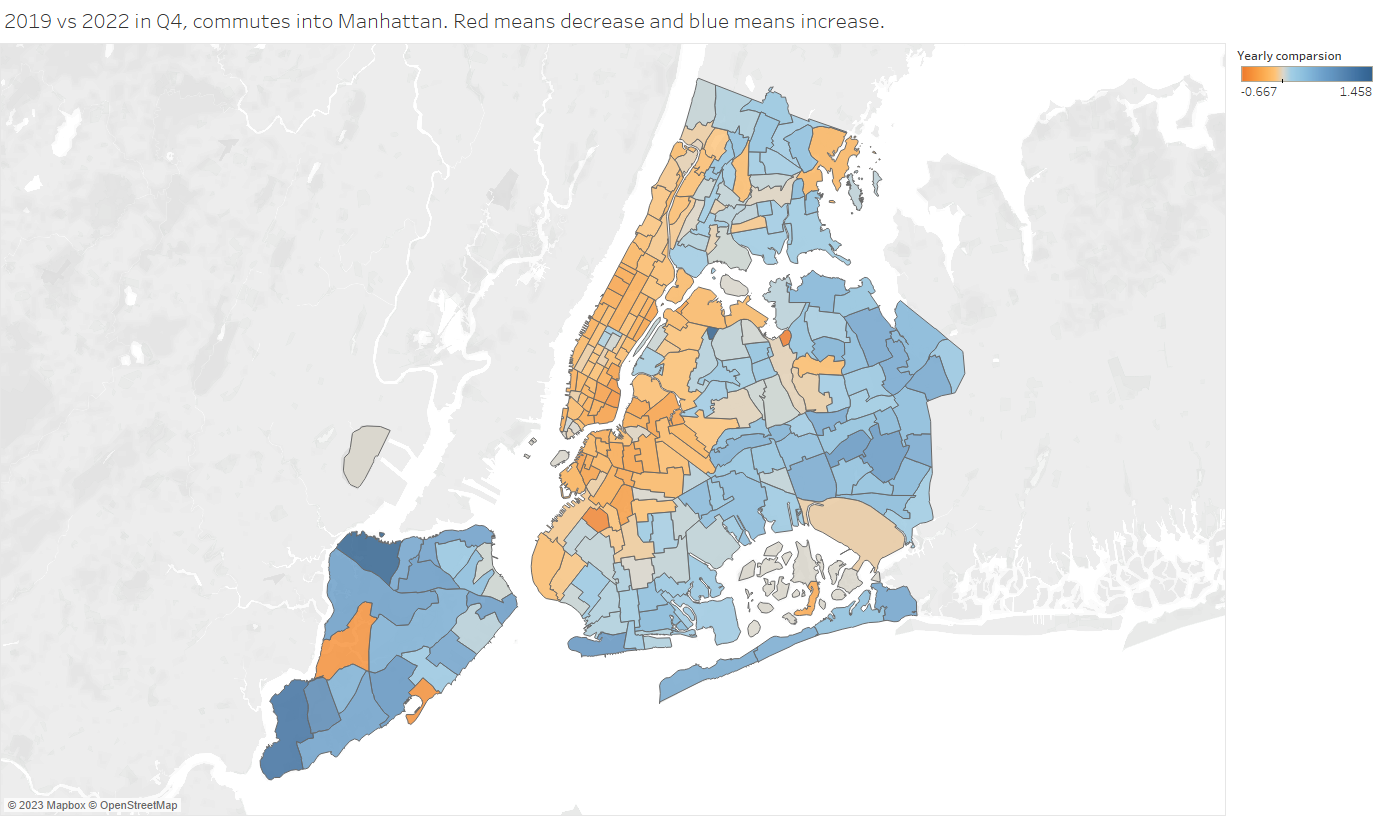

In [22]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Morning_Commutes_Q42019vsQ42022.png"
Image(filename=image_path)
#below image comes from a tableau analysis

This is exceptionally clear! Outer borough neighborhoods are commuting into the city more while Manhattan and adjacent BK neighborhoods -- the places where people have laptop jobs -- are commuting less. Also, it's a pretty similar map to the 2021 mayoral election. Call it a tale of two cities map! Yang's and Adams's commuter NYC vs. Kathryn Garcia's and Maya Wiley's remote work NYC. Not sure why commuting into the city via rideshare is UP in the outer boroughs (shouldn't it be the same as 2019?) -- my guess is it has to do with all the bad press about crime on the subway.

Sidenote: I reused this code to look at friday and saturday nights Q4 2019 vs. 2022. The same patterns emerge -- less commuting into Manhattan in the same neighborhoods, but the differences appeared to be less stark. E.g., BK neighborhoods where commuting was down 40% in the morning were down more like 15% on weekend nights ... not including this because I didn't quite flesh it out, but can come back to this later.

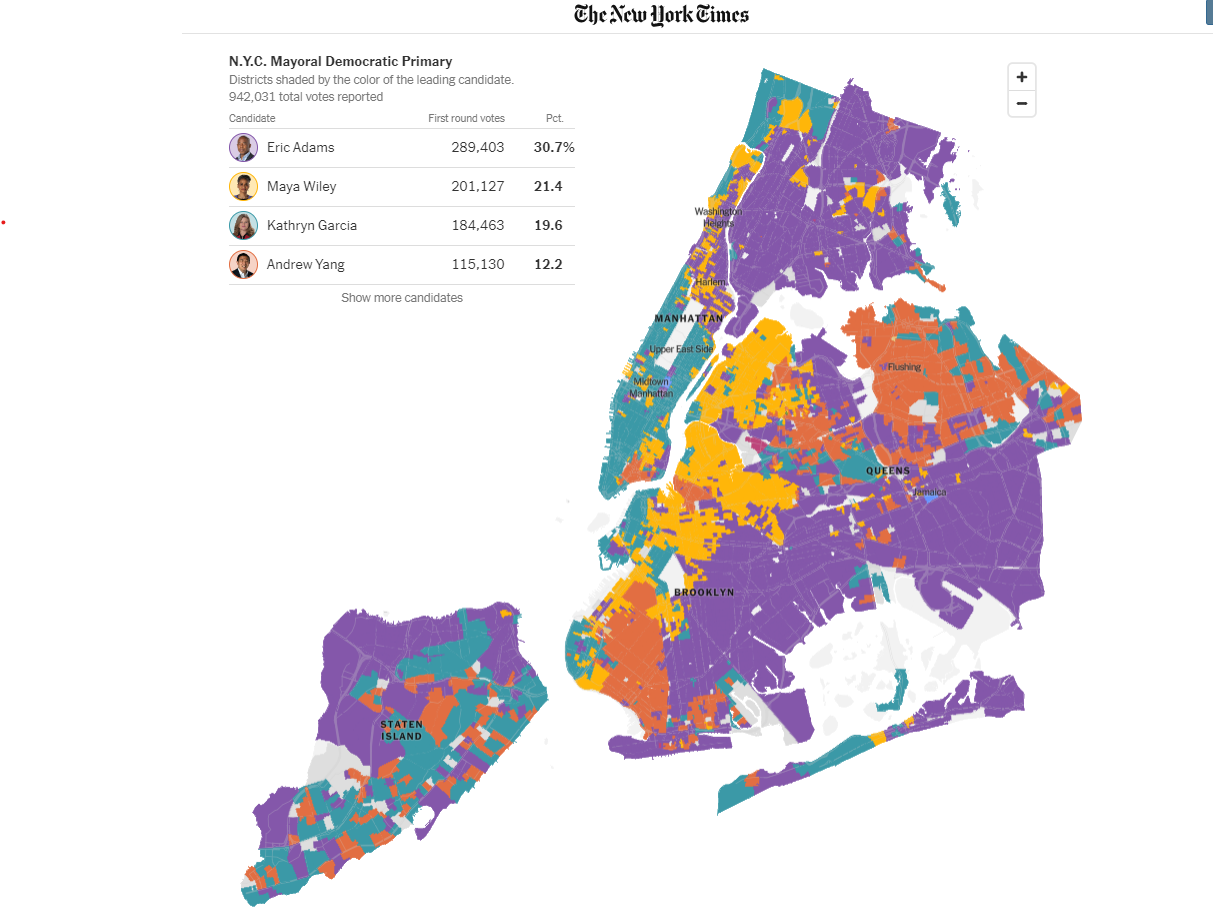

In [23]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\NYC_2021_Mayoral_Election.png"
Image(filename=image_path)


I'd like to try to do a hypothesis test. One idea I have: are people more likely to take an uber home when attending a baseball game if their team loses. Yankee stadium is an ideal place to study this -- there are 81 home baseball games every year and little else is in that taxi district, especially at night.

In [24]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2022_2023.parquet')
baseball_game_2022 = rideshares.loc[
    (
        (
            (rideshares['PULocationID'] == 247) #I eyeballled the Yankee stadium location then confirmed it by making sure that rides went up an unusual amount in the summer
        )
    & (rideshares['Year'] == 2022)
     & (rideshares['Hour']>=21 ) #after 9pm -- most games start at 7pm
    )
]
yankees_games_2022 = pd.read_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\Yankees_Games_2022.csv') 
#I created a clean csv of Yankee wins and losses in 2022 -- only home games.
yankees_games_2022['Date_Proper'] = pd.to_datetime(yankees_games_2022['Date'] + ', 2022', format="%A %b %d, %Y")
yankees_games_2022.drop('Date', inplace = True, axis = 1)
yankees_games_2022['Date'] = yankees_games_2022['Date_Proper']
baseball_game_2022['Date'] = pd.to_datetime(baseball_game_2022[['Year', 'Month', 'Day']])
baseball_game_2022 = baseball_game_2022.groupby('Date').sum()['trips']
baseball_game_2022 = pd.merge(baseball_game_2022, yankees_games_2022, on='Date', how='inner')
baseball_game_2022 = pd.get_dummies(baseball_game_2022, columns=['W/L'])
baseball_game_2022.rename(columns = {'W/L_W': "Win"}, inplace = True)
baseball_game_2022.drop(['Date_Proper','W/L_L','Date'], axis =1, inplace = True)
Wins_2022 = baseball_game_2022.loc[baseball_game_2022['Win']==True]
Losses_2022 = baseball_game_2022.loc[baseball_game_2022['Win']==False]

C:\Users\EvanSpiller\AppData\Local\Temp\ipykernel_21204\1200573583.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseball_game_2022['Date'] = pd.to_datetime(baseball_game_2022[['Year', 'Month', 'Day']])


In [25]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2021.parquet')
baseball_game_2021 = rideshares.loc[
    (
        (
            (rideshares['PULocationID'] == 247)
        )
    & (rideshares['Year'] == 2021)
     & (rideshares['Hour']>=21 )
    )
]
yankees_games_2021 = pd.read_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\Yankees_Games_2021.csv')
yankees_games_2021['Date_Proper'] = pd.to_datetime(yankees_games_2021['Date'] + ', 2021', format="%A %b %d, %Y")
yankees_games_2021.drop('Date', inplace = True, axis = 1)
yankees_games_2021['Date'] = yankees_games_2021['Date_Proper']
baseball_game_2021['Date'] = pd.to_datetime(baseball_game_2021[['Year', 'Month', 'Day']])
baseball_game_2021 = baseball_game_2021.groupby('Date').sum()['trips']
baseball_game_2021 = pd.merge(baseball_game_2021, yankees_games_2021, on='Date', how='inner')
baseball_game_2021 = pd.get_dummies(baseball_game_2021, columns=['W/L'])
baseball_game_2021.rename(columns = {'W/L_W': "Win"}, inplace = True)
baseball_game_2021.drop(['Date_Proper','W/L_L','Date'], axis =1, inplace = True)
Wins_2021 = baseball_game_2021.loc[baseball_game_2021['Win']==True]
Losses_2021 = baseball_game_2021.loc[baseball_game_2021['Win']==False]

C:\Users\EvanSpiller\AppData\Local\Temp\ipykernel_21204\2616725044.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseball_game_2021['Date'] = pd.to_datetime(baseball_game_2021[['Year', 'Month', 'Day']])


In [26]:
rideshares = pd.read_parquet(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\HVFHV_Compressed\Combined\full_compressed_HVFHV_2019_2020.parquet')
baseball_game_2019 = rideshares.loc[
    (
        (
            (rideshares['PULocationID'] == 247)
        )
    & (rideshares['Year'] == 2019)
     & (rideshares['Hour']>=21 )
    )
]
yankees_games_2019 = pd.read_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\Yankees_Games_2019.csv')
yankees_games_2019['Date_Proper'] = pd.to_datetime(yankees_games_2019['Date'] + ', 2019', format="%A %b %d, %Y")
yankees_games_2019.drop('Date', inplace = True, axis = 1)
yankees_games_2019['Date'] = yankees_games_2019['Date_Proper']
baseball_game_2019['Date'] = pd.to_datetime(baseball_game_2019[['Year', 'Month', 'Day']])
baseball_game_2019 = baseball_game_2019.groupby('Date').sum()['trips']
baseball_game_2019 = pd.merge(baseball_game_2019, yankees_games_2019, on='Date', how='inner')
baseball_game_2019 = pd.get_dummies(baseball_game_2019, columns=['W/L'])
baseball_game_2019.rename(columns = {'W/L_W': "Win"}, inplace = True)
baseball_game_2019.drop(['Date_Proper','W/L_L','Date'], axis =1, inplace = True)
Wins_2019 = baseball_game_2019.loc[baseball_game_2019['Win']==True]
Losses_2019 = baseball_game_2019.loc[baseball_game_2019['Win']==False]

C:\Users\EvanSpiller\AppData\Local\Temp\ipykernel_21204\4216234549.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseball_game_2019['Date'] = pd.to_datetime(baseball_game_2019[['Year', 'Month', 'Day']])


In [27]:
Wins = pd.concat([Wins_2019,Wins_2021, Wins_2022], axis=0)
Losses = pd.concat([Losses_2019, Losses_2021, Losses_2022], axis=0)


In [28]:
Wins.shape[0]+Losses.shape[0] # just a sanity check -- 81 home games a year * 3 years = 243

243

In [37]:
from scipy import stats

two_sample_test = stats.ttest_ind(Wins['trips'], Losses['trips']) 

print("Mean # of trips on win nights: ", Wins.mean()[0])
print("Mean # of trips on loss nights: ", Losses.mean()[0])
print("pvalue: ",two_sample_test[1])


Mean # of trips on win nights:  731.24375
Mean # of trips on loss nights:  702.7469879518072
pvalue:  0.402021064169119


In [57]:
rideshares['cost'] = rideshares['tips_sum'] + rideshares['driver_pay_sum']
rideshares['cost'].sum()
#5,646,542,598 = 5.6bn dollars spent on rideshares from 2019-2020

5646542598.210035

No statistical significance between the amount of rideshare rides on win nights vs. loss nights. I could go back and account for day games but, frankly, the p-value isn't close to .05 (and it was closer to .05 when I did only 2022).

Still I have two takeaways from this experiment: a. It tends to be difficult to get statistically significant info out of single taxi districts, especially when you have to further segment by days and times b. Null hypotheses tend to be proven wrong (pval < .05>) when subjects have a clear incentive to change their behavior -- soft hypotheses, like losing will make people sad so they get an Uber or Lyft -- rarely prove confirmable.

On that note, I might have more luck finding a correlation between run differential and the time people leave a baseball -- it's certainly true that people leave bad games early.

<b> Key takeaways from EDA so far: </b>

1. This is a HUGE dataset. Just rideshare rides from 2019 - May 2023 = 840M rides
2. It's also hugely consequential: in 2019 and 2020, 5.6 billion dollars were spent on rideshares, excluding tolls.
3. Most rides are short. The most common ride is probably about a mile. After that, ride length declines exponentially. I know this for January but it appears to be true all over (will need to confirm)
4. This is a very fruitful data set for looking at pandemic trends in NYC.
5. This is also a very fruitful dataset for looking at how NYC changed from before to after the pandemic.
6. Even with 840M trips to look at, segmenting single taxi districts and then digging deeper can make it hard to find trends. E.g., I got a great map by looking at trips into Manhattan but another digression (not in this notebook) about commutes into Times Square got me a very uneven map  with few insights